# Práctica 4: Modelos del Lenguaje Neuronales

**Fecha de entrega: 6 de abril de 2025 11:59pm**

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

### Extra (0.5 pts):

- Correr el modelo de Bengio pero aplicando una técnica de subword tokenization al corpus y hacer generación del lenguaje

* La generación del lenguaje debe ser secuencias de palabras (no subwords)

In [ ]:
import torch
from torch import nn
import nltk
from nltk.corpus import reuters
from nltk.corpus import stopwords
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import string
from sklearn.metrics.pairwise import cosine_similarity
from nltk import ngrams

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def preprocess_corpus(corpus: list[str]) -> list[str]:
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        result.append("")
        result.insert(0, "")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

def get_words_freqs(corpus: list[list[str]]):
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

UNK_LABEL = "<UNK>"
def get_words_indexes(words_freqs: dict) -> dict:
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        if words_freqs[word] == 1:
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx
    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [ ]:
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

In [ ]:
corpus = preprocess_corpus(reuters.sents())


In [ ]:
words_freqs = get_words_freqs(corpus)

In [ ]:
count = 0
for word, freq in words_freqs.items():
    if freq == 1 and count <= 10:
        print(word, freq)
        count += 1

inflict 1
sheen 1
avowed 1
kilolitres 1
janunary 1
pineapples 1
hasrul 1
paian 1
sawn 1
goodall 1
bundey 1


In [ ]:
words_indexes, index_to_word = get_words_indexes(words_freqs)

In [ ]:
def get_word_id(words_indexes: dict, word: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK
    """
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)

In [ ]:



# Trigram Neural Network Model
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

#Realizamos una pequeña configuración para que el load funcionara bien con el dispositivo actual
def get_model(path: str, device='cpu') -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)
    model_loaded.load_state_dict(torch.load(path,map_location=device))
    model_loaded.eval()
    return model_loaded

#Creamos una función para obtener las n palabras más similares a una palabra dada mediante la similitud coseno
def topn_sim_words(word,word_embeddings, n=10):
    """Obtiene las n palabras más similares a una dada mediante la similitud coseno"""
    similitudes={}
    #print(similitudes)
    if word in word_embeddings:
     embedding_word= word_embeddings[word]
     #print(embedding_word)
     for words,embedding in word_embeddings.items():
        if words==word:
            continue
        words_embedding= embedding

        similitudes[words]=cosine_similarity(embedding_word.reshape(1,-1),words_embedding.reshape(1,-1))[0][0]
     #print(similitudes)
     similitudes_ord=sorted(similitudes.items(),key=lambda x:x[1],reverse=True)
     return similitudes_ord[:n]
    else:
     return None



Convertiremos los trigramas obtenidos a secuencias de idx, y preparamos el conjunto de entrenamiento $x$ y $y$

- x: Contexto
- y: Predicción de la siguiente palabra

In [ ]:
def get_train_test_data(corpus: list[list[str]], words_indexes: dict, n: int) -> tuple[list, list]:
    """Obtiene el conjunto de train y test

    Requerido en el step de entrenamiento del modelo neuronal
    """
    x_train = []
    y_train = []
    for sent in corpus:
        n_grams = ngrams(sent, n)
        for w1, w2, w3 in n_grams:
            x_train.append([get_word_id(words_indexes, w1), get_word_id(words_indexes, w2)])
            y_train.append([get_word_id(words_indexes, w3)])
    return x_train, y_train

### Preparando Pytorch

$x' = e(x_1) \oplus e(x_2)$

$h = \tanh(W_1 x' + b)$

$y = softmax(W_2 h)$

In [ ]:
# cargamos bibliotecas
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [ ]:
# Setup de parametros
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
BATCH_SIZE = 256
H = 100
torch.manual_seed(42)
# Tamaño del Vocabulario
V = len(words_indexes)

In [ ]:
x_train, y_train = get_train_test_data(corpus, words_indexes, n=3)

In [ ]:
import numpy as np

train_set = np.concatenate((x_train, y_train), axis=1)
# partimos los datos de entrada en batches
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)

### Creamos la arquitectura del modelo

In [ ]:
# Trigram Neural Network Model
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

In [ ]:
# Seleccionar la GPU si está disponible
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

# 1. Pérdida. Negative log-likelihood loss
loss_function = nn.NLLLoss()

# 2. Instanciar el modelo y enviarlo a device
model = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)

# 3. Optimización. ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

# ------------------------- TRAIN & SAVE MODEL ------------------------
EPOCHS = 3
for epoch in range(EPOCHS):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch))
    for it, data_tensor in enumerate(train_loader):
        # Mover los datos a la GPU
        context_tensor = data_tensor[:,0:2].to(device)
        target_tensor = data_tensor[:,2].to(device)

        model.zero_grad()

        # FORWARD:
        log_probs = model(context_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # BACKWARD:
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print("Training Iteration {} of epoch {} complete. Loss: {}; Time taken (s): {}".format(it, epoch, loss.item(), (time.time()-st)))
            st = time.time()

    # saving model
    model_path = f'drive/MyDrive/LM_neuronal/model_{device}_context_{CONTEXT_SIZE}_epoch_{epoch}.dat'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved for epoch={epoch} at {model_path}")


Training on device cuda

--- Training model Epoch: 0 ---
Training Iteration 0 of epoch 0 complete. Loss: 9.935929298400879; Time taken (s): 0.015403509140014648
Training Iteration 500 of epoch 0 complete. Loss: 5.805361270904541; Time taken (s): 2.892514228820801
Training Iteration 1000 of epoch 0 complete. Loss: 5.33011531829834; Time taken (s): 1.959472894668579
Training Iteration 1500 of epoch 0 complete. Loss: 3.987616777420044; Time taken (s): 1.9740490913391113
Training Iteration 2000 of epoch 0 complete. Loss: 5.0693464279174805; Time taken (s): 1.9732966423034668
Training Iteration 2500 of epoch 0 complete. Loss: 4.618434429168701; Time taken (s): 1.9754352569580078
Training Iteration 3000 of epoch 0 complete. Loss: 4.09101676940918; Time taken (s): 1.9781250953674316
Training Iteration 3500 of epoch 0 complete. Loss: 4.583200931549072; Time taken (s): 2.0415918827056885
Training Iteration 4000 of epoch 0 complete. Loss: 5.592966079711914; Time taken (s): 2.0345163345336914
Tra

In [ ]:
model

TrigramModel(
  (embeddings): Embedding(20055, 200)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=20055, bias=True)
)

In [ ]:
def get_model(path: str) -> TrigramModel:
    """Obtiene modelo de pytorch desde disco"""
    model_loaded = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H)
    model_loaded.load_state_dict(torch.load(path))
    model_loaded.eval()
    return model_loaded

In [ ]:
PATH = "drive/MyDrive/LM_neuronal/model_cuda_4.dat"

In [ ]:
#model = get_model(PATH)
W1 = "<BOS>"
W2 = "my"

IDX1 = get_word_id(words_indexes, W1)
IDX2 = get_word_id(words_indexes, W2)

#Obtenemos Log probabidades p(W3|W2,W1)
probs = model(torch.tensor([[IDX1,  IDX2]]).to(device)).detach().tolist()

In [ ]:
# Creamos diccionario con {idx: logprob}
model_probs = {}
for idx, p in enumerate(probs[0]):
  model_probs[idx] = p

# Sort:
model_probs_sorted = sorted(((prob, idx) for idx, prob in model_probs.items()), reverse=True)

# Printing word  and prob (retrieving the idx):
topcandidates = 0
for prob, idx in model_probs_sorted:
  #Retrieve the word associated with that idx
  word = index_to_word[idx]
  print(idx, word, prob)

  topcandidates += 1

  if topcandidates > 10:
    break

31 <UNK> -3.6717288494110107
4853 fired -3.776751756668091
5123 body -3.7999484539031982
11069 watching -3.897939443588257
11113 mind -4.336875915527344
211 chairman -4.582357406616211
986 subsidiary -4.627180099487305
1259 pulp -4.695070266723633
3202 case -4.7349090576171875
2384 runs -4.80452823638916
132 co -4.879672050476074


In [ ]:
# Extraer los embeddings del modelo entrenado
embedding_weights = model.embeddings.weight.data.cpu().numpy()

# Crear un diccionario: {palabra: vector_embedding}
word_embeddings = {word: embedding_weights[idx] for word, idx in words_indexes.items() if idx < embedding_weights.shape[0]}


In [ ]:
# Lista de palabras vacías en inglés
stop_words = set(stopwords.words('english'))

# Elegir las N palabras más frecuentes (no stopwords ni puntuación)
N = 200
words_freq_sorted = sorted(words_freqs.items(), key=lambda x: x[1], reverse=True)

selected_words = []
for word, freq in words_freq_sorted:
    if word.lower() not in stop_words and word not in string.punctuation and word in word_embeddings:
        selected_words.append(word)
    if len(selected_words) >= N:
        break

# Embeddings correspondientes
selected_embeddings = np.array([word_embeddings[word] for word in selected_words])


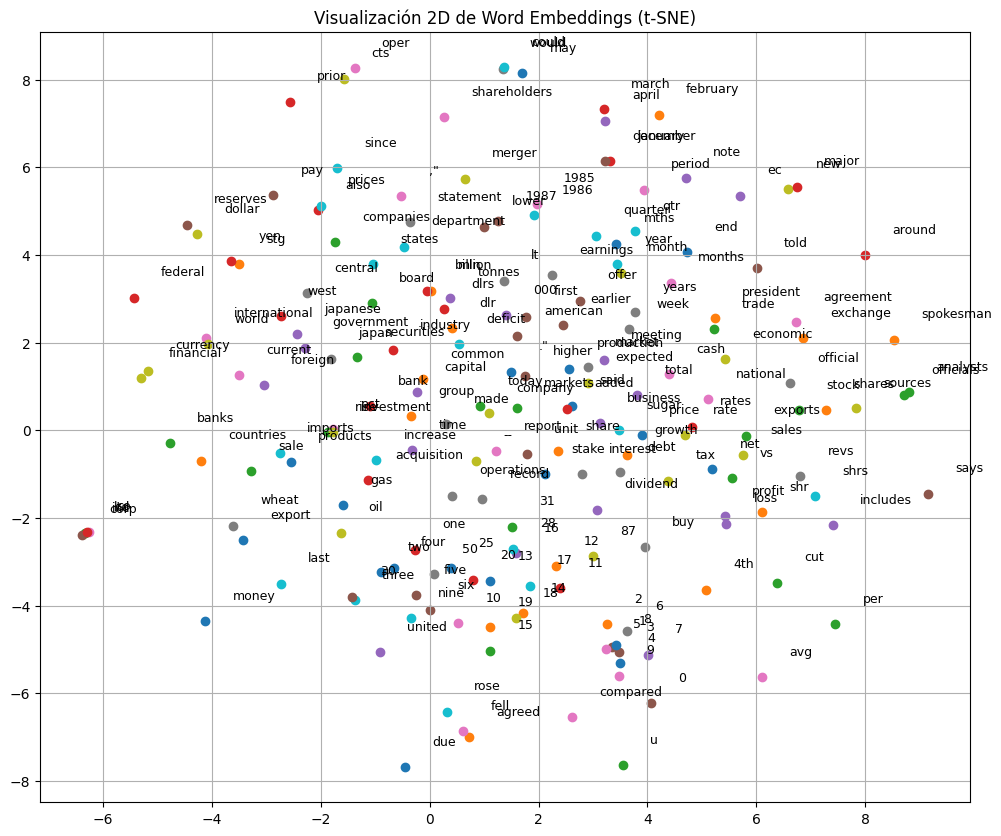

In [ ]:
# Primero reducimos a 50 dimensiones con PCA (para mejorar t-SNE)
pca = PCA(n_components=50)
reduced = pca.fit_transform(selected_embeddings)

# Luego aplicamos t-SNE a 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(reduced)

# Visualización
plt.figure(figsize=(12, 10))
for i, word in enumerate(selected_words):
    x, y = tsne_result[i, 0], tsne_result[i, 1]
    plt.scatter(x, y)
    plt.text(x+0.5, y+0.5, word, fontsize=9)
plt.title("Visualización 2D de Word Embeddings (t-SNE)")
plt.grid(True)
plt.show()


In [ ]:
word = "oil"
similar = topn_sim_words(word, word_embeddings, n=10)

if similar:
    print(f"Palabras más similares a '{word}':")
    for w, score in similar:
        print(f"{w}: {score:.4f}")
else:
    print(f"La palabra '{word}' no está en el vocabulario.")


Palabras más similares a 'oil':
annnounced: 0.2685
tunnels: 0.2520
centrally: 0.2492
exportable: 0.2477
ibj: 0.2436
kwvt: 0.2425
refining: 0.2402
halmi: 0.2401
adapting: 0.2361
plambeck: 0.2354


In [ ]:
word = "king"
similar = topn_sim_words(word, word_embeddings, n=10)

if similar:
    print(f"Palabras más similares a '{word}':")
    for w, score in similar:
        print(f"{w}: {score:.4f}")
else:
    print(f"La palabra '{word}' no está en el vocabulario.")

Palabras más similares a 'king':
clifford: 0.3005
oruro: 0.2913
)....: 0.2788
malaya: 0.2781
hfcs: 0.2571
local: 0.2472
elk: 0.2444
throughout: 0.2352
57: 0.2313
kent: 0.2311


In [ ]:
word = "problems"
similar = topn_sim_words(word, word_embeddings, n=10)

if similar:
    print(f"Palabras más similares a '{word}':")
    for w, score in similar:
        print(f"{w}: {score:.4f}")
else:
    print(f"La palabra '{word}' no está en el vocabulario.")

Palabras más similares a 'problems':
checkrobot: 0.2865
overheads: 0.2720
roffman: 0.2718
valuation: 0.2642
revised: 0.2633
productivity: 0.2575
margx: 0.2545
alleghney: 0.2518
flank: 0.2415
shake: 0.2384


In [ ]:
word = "stock"
similar = topn_sim_words(word, word_embeddings, n=10)

if similar:
    print(f"Palabras más similares a '{word}':")
    for w, score in similar:
        print(f"{w}: {score:.4f}")
else:
    print(f"La palabra '{word}' no está en el vocabulario.")

Palabras más similares a 'stock':
shares: 0.2886
untapped: 0.2606
cgrt: 0.2534
reminder: 0.2473
earner: 0.2460
mercantile: 0.2371
maturing: 0.2365
xebec: 0.2337
adjourned: 0.2318
committment: 0.2313


In [ ]:
def analogy(w1, w2, w3, word_embeddings):
    if all(w in word_embeddings for w in [w1, w2, w3]):
        vec = word_embeddings[w1] - word_embeddings[w2] + word_embeddings[w3]
        sims = {w: cosine_similarity(vec.reshape(1, -1), emb.reshape(1, -1))[0][0]
                for w, emb in word_embeddings.items() if w not in {w1, w2, w3}}
        return sorted(sims.items(), key=lambda x: x[1], reverse=True)[:5]
    else:
        return None

result = analogy("king", "man", "queen", word_embeddings)
if result:
    for word, score in result:
        print(f"{word}: {score:.4f}")
else:
    print("Alguna de las palabras no está en el vocabulario.")


institution: 0.2639
berger: 0.2606
gis: 0.2551
gmed: 0.2500
brae: 0.2436


In [ ]:
result = analogy("industry", "manufacturing", "banking", word_embeddings)
if result:
    for word, score in result:
        print(f"{word}: {score:.4f}")
else:
    print("Alguna de las palabras no está en el vocabulario.")


mckibbin: 0.3111
subcommittee: 0.2725
idled: 0.2718
wyss: 0.2470
rwanda: 0.2455


In [ ]:
result = analogy("imports", "buy", "exports", word_embeddings)
if result:
    for word, score in result:
        print(f"{word}: {score:.4f}")
else:
    print("Alguna de las palabras no está en el vocabulario.")


gnp: 0.3550
fabk: 0.2952
assets: 0.2860
upward: 0.2595
europe: 0.2532


## Conclusión

En este experimento se utilizaron embeddings de palabras para explorar similitudes semánticas y analogías entre términos clave del dominio económico y general, como `"oil"`, `"king"`, `"problems"` y `"stock"`, así como para realizar pruebas de analogía semántica como `"king" - "man" + "queen"` y otras relacionadas con sectores económicos.

### 1. Similitud semántica directa

Se observó que los términos más similares a las palabras analizadas no siempre están relacionados semánticamente de forma intuitiva. Por ejemplo:

- Para `"oil"`, aparecen palabras como `"refining"` (relacionada), pero también otras como `"annnounced"` o `"kwvt"`, lo cual sugiere que los embeddings fueron entrenados en un corpus donde las asociaciones no siempre siguen un patrón semántico claro.
- `"stock"` devuelve `"shares"` y `"earner"`, que sí son coherentes con el contexto financiero.
- En cambio, `"king"` devuelve `"clifford"`, `"oruro"` o `"malaya"`, lo que sugiere una mezcla de nombres propios o entidades geográficas.

Esto indica que el modelo de embeddings probablemente fue entrenado sobre un corpus donde el contexto de las palabras no es puramente semántico sino que está fuertemente influenciado por entidades del mundo real (posiblemente noticias, empresas, personas o ubicaciones).

### 2. Analogías semánticas

Las pruebas de analogía muestran un comportamiento similar:

- La clásica analogía `"king" - "man" + "queen"` no devuelve palabras directamente relacionadas con el concepto de "reina", sino otras entidades como `"institution"` o `"berger"`, lo que confirma la posible limitación del modelo en captar relaciones semánticas humanas/familiares.
- En el caso de `"industry" - "manufacturing" + "banking"`, se esperaría encontrar algo como `"finance"` o `"services"`, pero aparecen `"mckibbin"` o `"idled"`, lo que sugiere relaciones menos conceptuales y más contextuales o documentales.
- La analogía `"imports" - "buy" + "exports"` da un resultado más prometedor con `"gnp"` y `"assets"`, lo cual tiene sentido macroeconómico.
